In [1]:
from sklearn.datasets import load_diabetes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score,classification_report
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [ ]:
#1.1 Load Diabetes Data,Correlation Matrix and Heatmap Matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


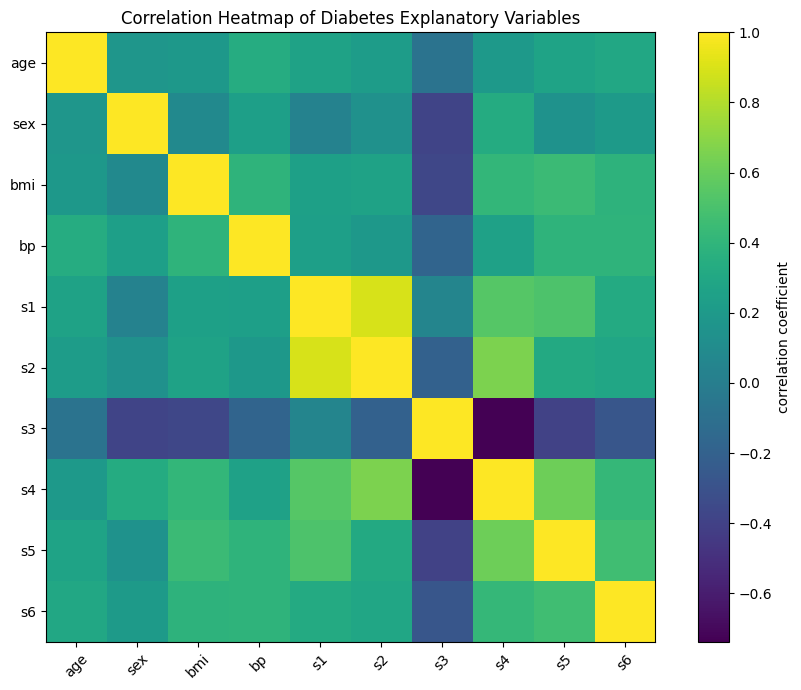

In [3]:
diabetes = load_diabetes()
X = pd.DataFrame(diabetes.data,
                 columns=diabetes.feature_names)
corr_matrix = X.corr()

plt.figure(figsize=(9, 7))
plt.imshow(corr_matrix, interpolation='nearest')
plt.colorbar(label='correlation coefficient')
plt.xticks(range(len(corr_matrix.columns)),
           corr_matrix.columns,
           rotation=45)
plt.yticks(range(len(corr_matrix.columns)),
           corr_matrix.columns)
plt.title("Correlation Heatmap of Diabetes Explanatory Variables")

plt.tight_layout()
plt.show()

In [ ]:
#1.3 Multivariate Linear Regression

In [4]:
y = diabetes.target
X_const = sm.add_constant(X)
model = sm.OLS(y, X_const).fit()
print(model.summary())

y_pred = model.predict(X_const)
mse = mean_squared_error(y, y_pred)
print("Mean Squared Error (MSE):", mse)

adj_r2 = model.rsquared_adj
print("Adjusted R-squared:", adj_r2)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     46.27
Date:                Sun, 11 Jan 2026   Prob (F-statistic):           3.83e-62
Time:                        10:33:51   Log-Likelihood:                -2386.0
No. Observations:                 442   AIC:                             4794.
Df Residuals:                     431   BIC:                             4839.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        152.1335      2.576     59.061      0.0

In [ ]:
#1.5 Define Forward Selection,Compute MSE and R²

In [5]:
def forward_selection(X, y, significance_level=0.05):
    selected_features = []
    remaining_features = list(X.columns)

    while len(remaining_features) > 0:
        pvals = pd.Series(index=remaining_features, dtype=float)

        for feature in remaining_features:
            model = sm.OLS(
                y,
                sm.add_constant(X[selected_features + [feature]])
            ).fit()
            pvals[feature] = model.pvalues[feature]

        min_pval = pvals.min()

        if min_pval < significance_level:
            best_feature = pvals.idxmin()
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
        else:
            break

    return selected_features
selected_vars = forward_selection(X, y)
print("Selected variables:", selected_vars)

X_stepwise = sm.add_constant(X[selected_vars])
stepwise_model = sm.OLS(y, X_stepwise).fit()
print(stepwise_model.summary())

y_pred_stepwise = stepwise_model.predict(X_stepwise)
mse_stepwise = mean_squared_error(y, y_pred_stepwise)
print("Stepwise Model MSE:", mse_stepwise)

r2_stepwise = stepwise_model.rsquared
print("Stepwise Model R-squared:", r2_stepwise)


Selected variables: ['bmi', 's5', 'bp', 's1', 'sex', 's2']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     76.95
Date:                Sun, 11 Jan 2026   Prob (F-statistic):           3.01e-65
Time:                        10:34:44   Log-Likelihood:                -2387.3
No. Observations:                 442   AIC:                             4789.
Df Residuals:                     435   BIC:                             4817.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

In [ ]:
#2.2 Loading the titanic dataset and calculating probability of survival for a passenger

In [12]:
titanic = pd.read_csv('/content/drive/My Drive/Colab Notebooks/titanic3.csv')
titanic.head()

titanic['survived']
survival_probability = titanic['survived'].mean()
survival_probability

print(f"Probability of survival: {survival_probability:.3f}")

Probability of survival: 0.382


In [ ]:
#2.3 Table of survival Probabilities broken down by passenger class, gender and age.

In [14]:
titanic = pd.read_csv('/content/drive/My Drive/Colab Notebooks/titanic3.csv')

titanic['age_group'] = titanic['age'].apply(lambda x: 'Child' if x < 18 else 'Adult')

survival_table = titanic.groupby(['pclass', 'sex', 'age_group'])['survived'].mean().reset_index()
survival_table.rename(
    columns={'survived': 'survival_probability'}, inplace=True
    )
survival_table['survival_probability'] = survival_table['survival_probability'].round(3)
print("Survival probabilities by passenger class, gender, and age:")
print(survival_table.to_string(index=False))

Survival probabilities by passenger class, gender, and age:
 pclass    sex age_group  survival_probability
      1 female     Adult                 0.971
      1 female     Child                 0.875
      1   male     Adult                 0.320
      1   male     Child                 0.857
      2 female     Adult                 0.864
      2 female     Child                 1.000
      2   male     Adult                 0.090
      2   male     Child                 0.733
      3 female     Adult                 0.476
      3 female     Child                 0.543
      3   male     Adult                 0.141
      3   male     Child                 0.233


In [ ]:
#2.4 Build logistic regression model for survival based on passenger class, sex, and age

In [15]:
print("Columns in dataset:", titanic.columns.tolist())
print("\nFirst few rows:")
print(titanic[['pclass', 'sex', 'age', 'survived']].head())

titanic['sex_binary'] = titanic['sex'].map({'female': 1, 'male': 0})

pclass_dummies = pd.get_dummies(titanic['pclass'], prefix='class', drop_first=True)

X = pd.concat([pclass_dummies, titanic[['sex_binary', 'age']]], axis=1)
X = sm.add_constant(X)
y = titanic['survived']

combined = pd.concat([X, y], axis=1).dropna()
X_clean = combined.iloc[:, :-1]
y_clean = combined.iloc[:, -1].astype(float)
X_clean_encoded = X_clean.astype(float)

print("\nX data types:")
print(X_clean_encoded.dtypes)
print("\ny unique values:", y_clean.unique())

logit_model = sm.Logit(y_clean, X_clean_encoded)
logit_result = logit_model.fit(disp=False)

print("Logistic Regression Model Summary:")
print(logit_result.summary())

params_df = pd.DataFrame({
    'Variable': logit_result.params.index,
    'Coefficient': logit_result.params.values,
    'P-value': logit_result.pvalues.values
})
print("\nParameter Estimates:")
print(params_df.to_string(index=False))

print("\nStatistical Significance (alpha = 0.05):")
for var, pval in zip(params_df['Variable'], params_df['P-value']):
    sig = "Significant" if pval < 0.05 else "Not significant"
    print(f"{var}: p = {pval:.4f} -> {sig}")

Columns in dataset: ['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket', 'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest', 'age_group']

First few rows:
   pclass     sex    age  survived
0       1  female  29.00         1
1       1    male   0.92         1
2       1  female   2.00         0
3       1    male  30.00         0
4       1  female  25.00         0

X data types:
const         float64
class_2       float64
class_3       float64
sex_binary    float64
age           float64
dtype: object

y unique values: [1. 0.]
Logistic Regression Model Summary:
                           Logit Regression Results                           
Dep. Variable:               survived   No. Observations:                 1046
Model:                          Logit   Df Residuals:                     1041
Method:                           MLE   Df Model:                            4
Date:                Sun, 11 Jan 2026   Pseudo R-squ.:                  0.3055
Time:         

In [ ]:
#2.5 Model performance measured by classification accuracy from confusion matrix

In [16]:
print("Columns:", titanic.columns.tolist())

if 'survived' not in titanic.columns:

    if 'Survived' in titanic.columns:
        titanic.rename(columns={'Survived': 'survived'}, inplace=True)
    elif 'survival' in titanic.columns:
        titanic.rename(columns={'survival': 'survived'}, inplace=True)

if 'pclass' not in titanic.columns:
    if 'Pclass' in titanic.columns:
        titanic.rename(columns={'Pclass': 'pclass'}, inplace=True)
    elif 'class' in titanic.columns:
        titanic.rename(columns={'class': 'pclass'}, inplace=True)

if 'sex' not in titanic.columns:
    if 'Sex' in titanic.columns:
        titanic.rename(columns={'Sex': 'sex'}, inplace=True)
    elif 'gender' in titanic.columns:
        titanic.rename(columns={'gender': 'sex'}, inplace=True)
titanic['sex'] = titanic['sex'].str.lower().map({'female': 1, 'male': 0})

pclass_dummies = pd.get_dummies(titanic['pclass'], prefix='class', drop_first=True)

X = pd.concat([pclass_dummies, titanic[['sex', 'age']]], axis=1)
X = sm.add_constant(X, has_constant='add')
y = titanic['survived']

data_clean = pd.concat([X, y], axis=1).dropna()
X_clean = data_clean.iloc[:, :-1]
y_clean = data_clean.iloc[:, -1].astype(int)

X_clean = X_clean.astype(float)

print("\nClean X shape:", X_clean.shape)
print("X dtypes:", X_clean.dtypes)
print("y unique values:", y_clean.unique())

logit_model = sm.Logit(y_clean, X_clean)
logit_result = logit_model.fit(disp=False)


print("LOGISTIC REGRESSION MODEL SUMMARY")

print(logit_result.summary())

y_pred_prob = logit_result.predict(X_clean)
y_pred = (y_pred_prob >= 0.5).astype(int)
cm = confusion_matrix(y_clean, y_pred)
tn, fp, fn, tp = cm.ravel()
accuracy = accuracy_score(y_clean, y_pred)

print("CONFUSION MATRIX & ACCURACY (In-sample)")
print("="*60)
print(f"Confusion Matrix:\n{cm}")
print(f"\nTN={tn}, FP={fp}, FN={fn}, TP={tp}")
print(f"Accuracy = ({tp} + {tn}) / {len(y_clean)} = {accuracy:.4f} ({accuracy*100:.2f}%)")

print("\nClassification Report:")
print(classification_report(y_clean, y_pred, target_names=['Not Survived', 'Survived']))

Columns: ['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket', 'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest', 'age_group', 'sex_binary']

Clean X shape: (1046, 5)
X dtypes: const      float64
class_2    float64
class_3    float64
sex        float64
age        float64
dtype: object
y unique values: [1 0]
LOGISTIC REGRESSION MODEL SUMMARY
                           Logit Regression Results                           
Dep. Variable:               survived   No. Observations:                 1046
Model:                          Logit   Df Residuals:                     1041
Method:                           MLE   Df Model:                            4
Date:                Sun, 11 Jan 2026   Pseudo R-squ.:                  0.3055
Time:                        10:48:35   Log-Likelihood:                -491.23
converged:                       True   LL-Null:                       -707.31
Covariance Type:            nonrobust   LLR p-value:                 3.110e-92

In [ ]:
#3.3 Download the 30 Dow Jones constituent stocks

In [17]:
tickers = [
    'MMM','AXP','AMGN','AAPL','BA','CAT','CVX','CSCO','KO','DIS',
    'DOW','GS','HD','HON','IBM','INTC','JNJ','JPM','MCD','MRK',
    'MSFT','NKE','PG','CRM','TRV','UNH','VZ','V','AMZN','WMT'
]
prices = yf.download(
    tickers,
    start="2020-01-01",
    end="2021-01-01"
)
print(prices.columns)
prices = yf.download(
    tickers,
    start="2020-01-01",
    end="2021-01-01"
)['Close']
returns = prices.pct_change().dropna()

corr_matrix = returns.corr()

pca = PCA()
pca.fit(corr_matrix)

loadings = pd.DataFrame(
    pca.components_.T,
    index=corr_matrix.columns,
    columns=[f'PC{i+1}' for i in range(len(corr_matrix.columns))]
)


/tmp/ipython-input-2142759242.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(
[*********************100%***********************]  30 of 30 completed
/tmp/ipython-input-2142759242.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(
[***                    7%                       ]  2 of 30 completed

MultiIndex([( 'Close', 'AAPL'),
            ( 'Close', 'AMGN'),
            ( 'Close', 'AMZN'),
            ( 'Close',  'AXP'),
            ( 'Close',   'BA'),
            ( 'Close',  'CAT'),
            ( 'Close',  'CRM'),
            ( 'Close', 'CSCO'),
            ( 'Close',  'CVX'),
            ( 'Close',  'DIS'),
            ...
            ('Volume',  'MMM'),
            ('Volume',  'MRK'),
            ('Volume', 'MSFT'),
            ('Volume',  'NKE'),
            ('Volume',   'PG'),
            ('Volume',  'TRV'),
            ('Volume',  'UNH'),
            ('Volume',    'V'),
            ('Volume',   'VZ'),
            ('Volume',  'WMT')],
           names=['Price', 'Ticker'], length=150)


[*********************100%***********************]  30 of 30 completed


In [ ]:
3.3 Bar plot of PC1 and PC2 (PCA Weight)

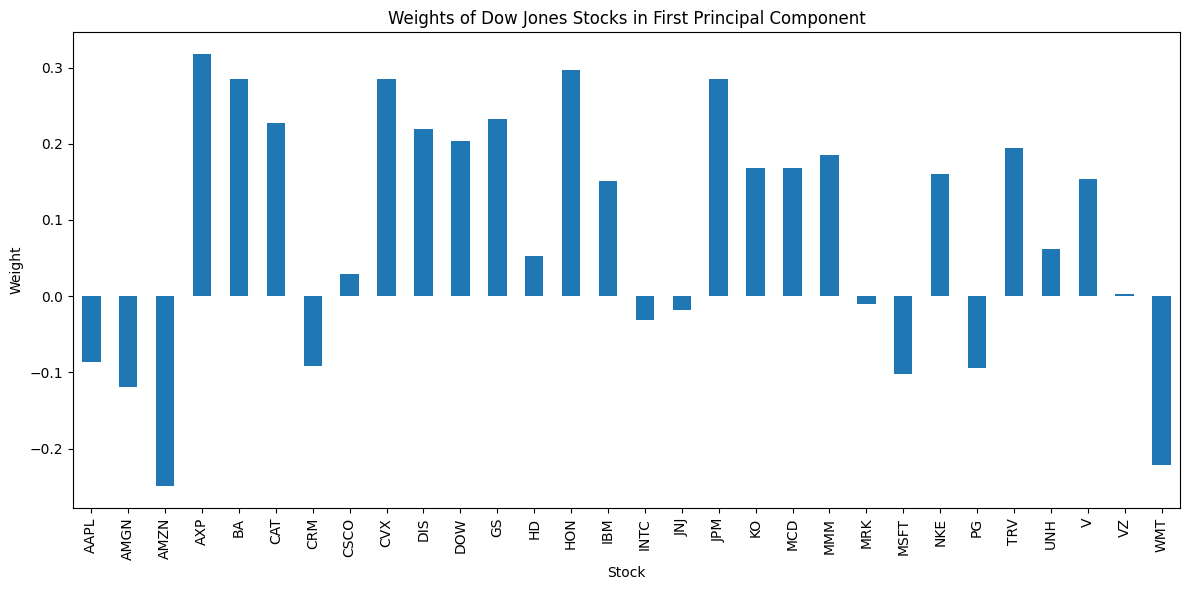

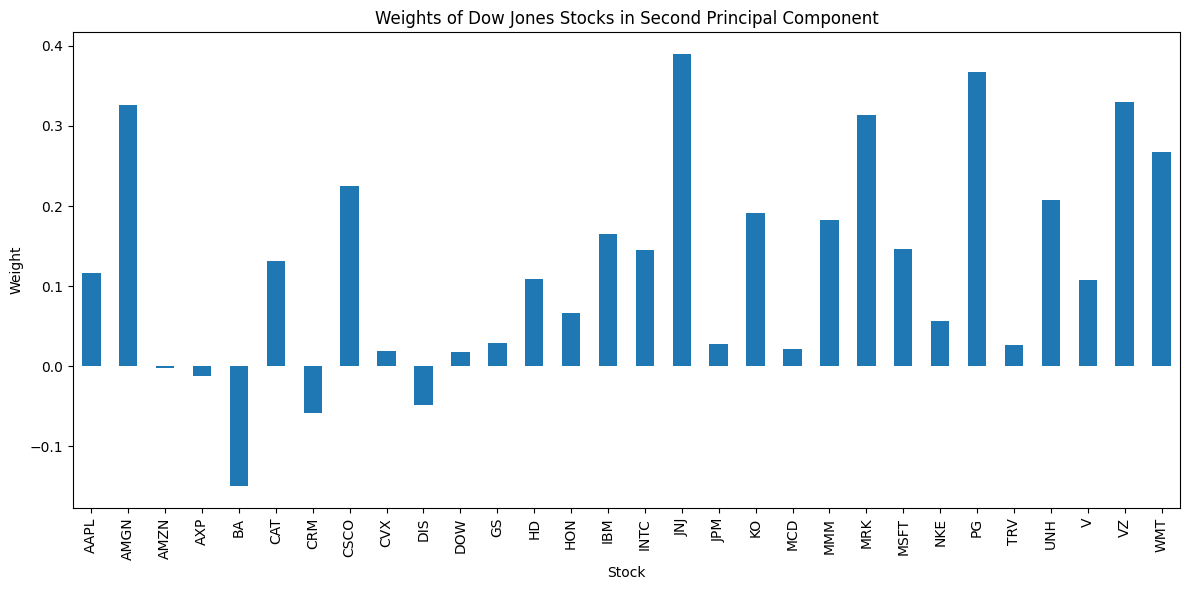

In [18]:
plt.figure(figsize=(12, 6))
loadings['PC1'].plot(kind='bar')
plt.title('Weights of Dow Jones Stocks in First Principal Component')
plt.ylabel('Weight')
plt.xlabel('Stock')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
loadings['PC2'].plot(kind='bar')
plt.title('Weights of Dow Jones Stocks in Second Principal Component')
plt.ylabel('Weight')
plt.xlabel('Stock')
plt.tight_layout()
plt.show()

In [ ]:
#3.4 Scree plot

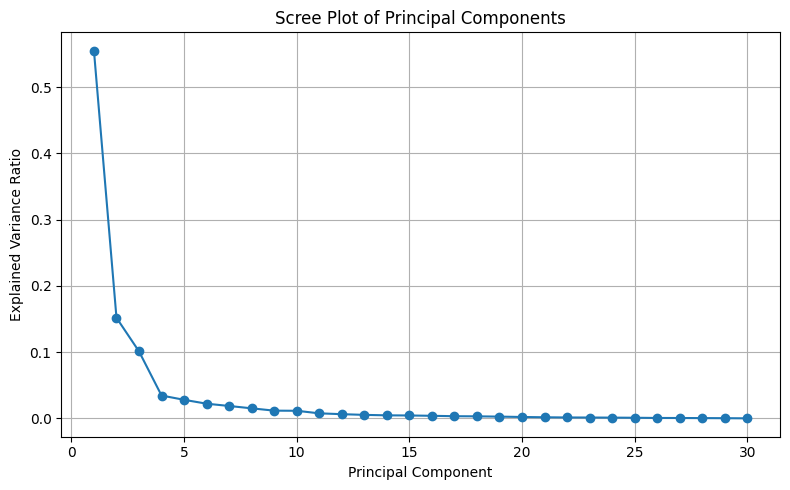

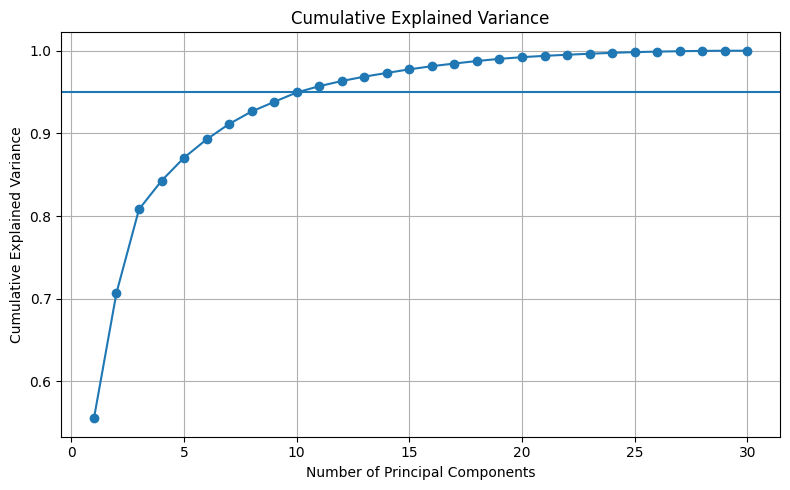

In [19]:
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(8, 5))
plt.plot(
    range(1, len(explained_variance) + 1),
    explained_variance,
    marker='o'
)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot of Principal Components')
plt.grid(True)
plt.tight_layout()
plt.show()

cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8, 5))
plt.plot(
    range(1, len(cumulative_variance) + 1),
    cumulative_variance,
    marker='o'
)
plt.xlabel('Number of Principal Components')
plt.axhline(0.95)
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#3.5 PCA scatter plot and outlier detection

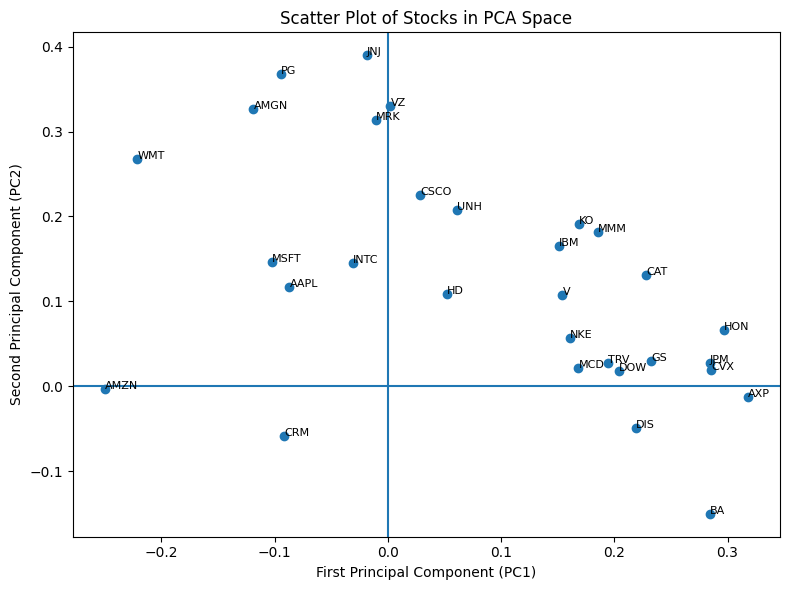

,Distance
Ticker,
AMZN,0.361288
WMT,0.341732
BA,0.337047


In [20]:
pc_scores = pd.DataFrame(
    pca.components_[:2].T,
    index=corr_matrix.columns,
    columns=['PC1', 'PC2']
)
plt.figure(figsize=(8, 6))
plt.scatter(pc_scores['PC1'], pc_scores['PC2'])

for stock in pc_scores.index:
    plt.text(pc_scores.loc[stock, 'PC1'],
             pc_scores.loc[stock, 'PC2'],
             stock,
             fontsize=8)

plt.xlabel('First Principal Component (PC1)')
plt.ylabel('Second Principal Component (PC2)')
plt.title('Scatter Plot of Stocks in PCA Space')
plt.axhline(0)
plt.axvline(0)
plt.tight_layout()
plt.show()

mean_point = pc_scores.mean()
mean_point
distances = np.sqrt(
    (pc_scores['PC1'] - mean_point['PC1'])**2 +
    (pc_scores['PC2'] - mean_point['PC2'])**2
)

distance_df = pd.DataFrame({
    'Distance': distances
}).sort_values(by='Distance', ascending=False)

distance_df.head(3)

In [10]:
import os
print(os.listdir())

['.config', 'drive', 'sample_data']
